# Language modelling using RNN

In [1]:
import keras
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Only let tensorflow backend use a portion of gpu, otherwise the program crashes time to time 
# (at least on my windows machine)
from keras import backend as K
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
config = tf.ConfigProto(gpu_options=gpu_options)
sess = tf.Session(config=config)
K.set_session(sess)

# Read data

In [3]:
# Format: Each line contain one sentences in Japanese word broken by Mecab (Total: 1M lines)
# This data is private, so feel free to replace it with any other data you might have
# Any language would be fine. 

with open('./data/private_japanese_corpus_1M.txt', encoding='utf-8') as f:
    sentences_raw = [x.rstrip() for x in f.readlines()]

In [4]:
# Sample sentences
# sentences_raw[0:1]

# Define Parameters

In [5]:
VOCAB_SIZE = 10000

EMBEDDING_SIZE = 256

NUM_RNN_UNITS = 256

BATCH_SIZE = 128

DATA_SIZE = None ## Calculate bellow

NUM_BATCHES = None ## Calculate bellow

MAX_LEN = None

# Preprocess data

In [6]:
# Calculate input_text, target_texts
input_texts = []
target_texts = []

for line in sentences_raw:
    if not line:
        continue
    input_line = '<sos> ' + line
    target_line = line + ' <eos>'

    input_texts.append(input_line)
    target_texts.append(target_line)

In [7]:
# Create tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, filters='')
tokenizer.fit_on_texts([x + ' <eos>' for x in input_texts])

In [8]:
# Transofrm input sequences
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [9]:
print('In Sequence Sample\t', input_sequences[0])
print('Out Sequence Sample\t', target_sequences[0:1])

In Sequence Sample	 [1, 373, 6, 3, 974, 632, 3, 4465, 20, 3, 2143, 13, 1774, 35, 12, 121, 164]
Out Sequence Sample	 [[373, 6, 3, 974, 632, 3, 4465, 20, 3, 2143, 13, 1774, 35, 12, 121, 164, 2]]


In [10]:
# Calculate parameters
DATA_SIZE = len(input_sequences)
NUM_BATCHES = int(DATA_SIZE/BATCH_SIZE) -2

In [11]:
MAX_LEN = max(len(s) for s in input_sequences)
MAX_LEN

141

In [12]:
# Padding input sequences (no need to do this for target sequences since one hot can be calculated without this step)
input_sequences_pad = pad_sequences(input_sequences, MAX_LEN, padding='post')

In [13]:
print(input_sequences_pad.shape)

(999069, 141)


# Create model

In [14]:
model = keras.Sequential()

In [15]:
model.add(keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_SIZE))
model.add(keras.layers.GRU(NUM_RNN_UNITS, input_shape=(MAX_LEN, EMBEDDING_SIZE), activation='relu', return_sequences=True))
model.add(keras.layers.Dense(VOCAB_SIZE, activation='softmax'))


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
gru_1 (GRU)                  (None, None, 256)         393984    
_________________________________________________________________
dense_1 (Dense)              (None, None, 10000)       2570000   
Total params: 5,523,984
Trainable params: 5,523,984
Non-trainable params: 0
_________________________________________________________________


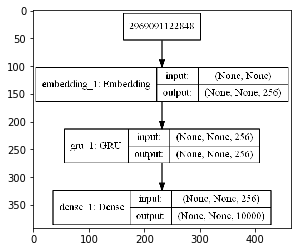

In [17]:
from keras.utils import plot_model
import matplotlib.image as mpimg

model_path = 'rnn-langmodel.png'
plot_model(model, model_path, show_shapes=True)

img=mpimg.imread(model_path)
imgplot = plt.imshow(img)
plt.show()

# Training 

In [18]:
# Define generator. Data is too large so needed to be divided into batch of batches.
def generator(input_sequences_pad = input_sequences_pad, target_sequences = target_sequences, batch_size = BATCH_SIZE):
    num_batch = int(len(input_sequences_pad)/ batch_size)
    while True:
        for i in range(num_batch-1):
            x = input_sequences_pad[batch_size*i: batch_size*(i+1)]
            y = np.zeros((int(batch_size), MAX_LEN, VOCAB_SIZE), dtype=np.bool)
            for i, sentence in enumerate(target_sequences[batch_size*i: batch_size*(i+1)]):
                for j, word_index in enumerate(sentence):
                    y[i, j, word_index] = 1
            yield x, y

In [19]:
# Define generator. Data is too large so needed to be divided into batch of batches.
def generator_rand(input_sequences_pad = input_sequences_pad, target_sequences = target_sequences, batch_size = BATCH_SIZE):  
    while True:
        rand_start = random.randint(0, len(input_sequences_pad)- BATCH_SIZE-1);
        x = input_sequences_pad[rand_start: rand_start+ batch_size]
        y = np.zeros((int(batch_size), MAX_LEN, VOCAB_SIZE), dtype=np.bool)
        for i, sentence in enumerate(target_sequences[rand_start: rand_start+ batch_size]):
            for j, word_index in enumerate(sentence):
                y[i, j, word_index] = 1
        yield x, y

In [20]:
DEFAULT_FOLDER = './data/models/v1/'
import os
from keras.models import model_from_json
def save_model(model, folder = DEFAULT_FOLDER):
    if not os.path.exists(folder):
        os.makedirs(folder)
    model_json = model.to_json()
    with open(folder + 'model.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(folder + "model.h5")
def load_model(folder=DEFAULT_FOLDER):
    with open(folder + 'model.json') as f:
        model_json = f.read()
    model = model_from_json(model_json)
    model.load_weights(folder + 'model.h5')
    return model

# Uncomment to train and save

In [21]:
#model.fit_generator(generator= generator, steps_per_epoch= NUM_BATCHES , epochs=10)
# Take about 2 hours with 1M lines of short sentences in GTX 1080

In [22]:
#save_model(model)

# Generation

In [23]:
# Load trained model
trained_model = load_model()

In [24]:
temp = [x for sentence in tokenizer.texts_to_sequences(['<sos>']) for x in sentence]
step = 1
for i in range(100):
    step_temp = min(len(temp), step)
    pred = trained_model.predict([temp[-step_temp:]])
    pred_index = np.argpartition(pred.reshape(-1), -10)[-10:]
    pred_index = np.random.choice(pred_index)
    if(tokenizer.index_word[pred_index] == '<eos>'):
        break;
    temp = temp + [pred_index]
# tokenizer.sequences_to_texts([temp[1:]]) # Cannot public the result

In [25]:
def release_gpu_memory():
    from keras import backend as K
    K.clear_session()
    import gc
    gc.collect()
    from numba import cuda
    cuda.select_device(0)
    cuda.close()
# Release memory when needed
# release_gpu_memory()